In [2]:
from PIL import Image
import os
import torch
import hashlib
import tarfile
import requests
import numpy as np
from tqdm import tqdm
from PIL import Image
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.transforms import v2
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

In [3]:
class LFWDataset(torch.utils.data.Dataset):
    _DATA = (
        # images
        ("http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz", None),
        # segmentation masks as ppm
        ("https://vis-www.cs.umass.edu/lfw/part_labels/parts_lfw_funneled_gt_images.tgz",
         "3e7e26e801c3081d651c8c2ef3c45cfc"),
    )


    def __init__(self, base_folder, transforms, download=True, split_name: str = 'train'):
        super().__init__()
        self.base_folder = base_folder
        # TODO your code here: if necessary download and extract the data
        '''
        if download:
            self.download_resources(base_folder)
        self.X = None
        self.Y = None
        raise NotImplementedError("Not implemented yet")'''
        if download:
            self.download_resources(base_folder)
        self.transforms = transforms
        self.split_name = split_name
        self.image_folder = os.path.join(base_folder, "lfw_funneled")
        #print(self.image_folder)
        self.mask_folder = os.path.join(base_folder, "parts_lfw_funneled_gt_images")
        #print(self.mask_folder)
        self.image_file_list, self.mask_file_list = self.get_file_lists()
        self.indices = self.get_split_indices()
            
    def get_file_lists(self):
        all_image_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(self.image_folder) for f in filenames if f.endswith('.jpg')]

        mask_file_list = [f for f in os.listdir(self.mask_folder) if f.endswith('.ppm')]
        mask_file_list = [os.path.join(self.mask_folder, f) for f in mask_file_list if os.path.isfile(os.path.join(self.mask_folder, f))]
        
        image_mask_file_list = [f.replace('._','').replace('.ppm', '.jpg') for f in os.listdir(self.mask_folder) if f.endswith('.ppm')]
        image_mask_file_set = set(image_mask_file_list)
        
        image_file_list = [f for f in all_image_files if os.path.isfile(f) and f.split("\\")[-1] in image_mask_file_set]
        #print(all_image_files[0])
        #print(image_file_list[0])
        
        
        return image_file_list, mask_file_list

    def get_split_indices(self):
        num_samples = len(self.image_file_list)
        if self.split_name == 'train':
            return list(range(num_samples // 2))
        elif self.split_name == 'test':
            return list(range(num_samples // 2, num_samples))
        else:
            raise ValueError("Invalid split_name. Use 'train' or 'test'.")
        
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # TODO your code here: return the idx^th sample in the dataset: image, segmentation mask
        # TODO your code here: if necessary apply the transforms
        # raise NotImplementedError("Not implemented yet")
        #print(self.image_file_list)
        image_filename = self.image_file_list[idx]
        maybe = image_filename.split("\\")[-1]
        maybe = maybe.replace('.jpg', '.ppm')
        #print(maybe)
        maybe2 = self.mask_folder + "\\" + maybe
        #print(maybe2)
        mask_filename = image_filename.replace('.jpg', '.ppm')
        mask_filename = maybe2

        #image_path = os.path.join(self.base_folder, image_filename)
        image_path = image_filename
        #mask_path = os.path.join(self.mask_folder, mask_filename)
        #print(mask_filename)
        mask_path = mask_filename
        #print(mask_path)
        
        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.transforms is not None:
            image = self.transforms(image)
            mask = self.transforms(mask)
        image = np.array(image)
        mask = np.array(mask)
        #print(mask)
        return image, mask

    def download_resources(self, base_folder):
        if not os.path.exists(base_folder):
            os.makedirs(base_folder)
        self._download_and_extract_archive(url=LFWDataset._DATA[1][0], base_folder=base_folder,
                                           md5=LFWDataset._DATA[1][1])
        self._download_and_extract_archive(url=LFWDataset._DATA[0][0], base_folder=base_folder, md5=None)

    def _download_and_extract_archive(self, url, base_folder, md5) -> None:
        """
          Downloads an archive file from a given URL, saves it to the specified base folder,
          and then extracts its contents to the base folder.

          Args:
          - url (str): The URL from which the archive file needs to be downloaded.
          - base_folder (str): The path where the downloaded archive file will be saved and extracted.
          - md5 (str): The MD5 checksum of the expected archive file for validation.
          """
        base_folder = os.path.expanduser(base_folder)
        filename = os.path.basename(url)

        self._download_url(url, base_folder, md5)
        archive = os.path.join(base_folder, filename)
        print(f"Extracting {archive} to {base_folder}")
        self._extract_tar_archive(archive, base_folder, True)

    def _retreive(self, url, save_location, chunk_size: int = 1024 * 32) -> None:
        """
            Downloads a file from a given URL and saves it to the specified location.

            Args:
            - url (str): The URL from which the file needs to be downloaded.
            - save_location (str): The path where the downloaded file will be saved.
            - chunk_size (int, optional): The size of each chunk of data to be downloaded. Defaults to 32 KB.
            """
        try:
            response = requests.get(url, stream=True)
            total_size = int(response.headers.get('content-length', 0))

            with open(save_location, 'wb') as file, tqdm(
                    desc=os.path.basename(save_location),
                    total=total_size,
                    unit='B',
                    unit_scale=True,
                    unit_divisor=1024,
            ) as bar:
                for data in response.iter_content(chunk_size=chunk_size):
                    file.write(data)
                    bar.update(len(data))

            print(f"Download successful. File saved to: {save_location}")

        except Exception as e:
            print(f"An error occurred: {str(e)}")

    def _download_url(self, url: str, base_folder: str, md5: str = None) -> None:
        """Downloads the file from the url to the specified folder

        Args:
            url (str): URL to download file from
            base_folder (str): Directory to place downloaded file in
            md5 (str, optional): MD5 checksum of the download. If None, do not check
        """
        base_folder = os.path.expanduser(base_folder)
        filename = os.path.basename(url)
        file_path = os.path.join(base_folder, filename)

        os.makedirs(base_folder, exist_ok=True)

        # check if the file already exists
        if self._check_file(file_path, md5):
            print(f"File {file_path} already exists. Using that version")
            return

        print(f"Downloading {url} to file_path")
        self._retreive(url, file_path)

        # check integrity of downloaded file
        if not self._check_file(file_path, md5):
            raise RuntimeError("File not found or corrupted.")

    def _extract_tar_archive(self, from_path: str, to_path: str = None, remove_finished: bool = False) -> str:
        """Extract a tar archive.

        Args:
            from_path (str): Path to the file to be extracted.
            to_path (str): Path to the directory the file will be extracted to. If omitted, the directory of the file is
                used.
            remove_finished (bool): If True , remove the file after the extraction.
        Returns:
            (str): Path to the directory the file was extracted to.
        """
        if to_path is None:
            to_path = os.path.dirname(from_path)

        with tarfile.open(from_path, "r") as tar:
            tar.extractall(to_path)

        if remove_finished:
            os.remove(from_path)

        return to_path

    def _compute_md5(self, filepath: str, chunk_size: int = 1024 * 1024) -> str:
        with open(filepath, "rb") as f:
            md5 = hashlib.md5()
            while chunk := f.read(chunk_size):
                md5.update(chunk)
        return md5.hexdigest()

    def _check_file(self, filepath: str, md5: str) -> bool:
        if not os.path.isfile(filepath):
            return False
        if md5 is None:
            return True
        return self._compute_md5(filepath) == md5

In [4]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        skip = x  # Save the output for skip connections
        x = self.pool(x)
        return x, skip

class Encoder(nn.Module):
    def __init__(self, channels_list):
        super(Encoder, self).__init__()
        self.blocks = nn.ModuleList([EncoderBlock(channels_list[i], channels_list[i+1]) for i in range(len(channels_list)-1)])

    def forward(self, x):
        skips = []
        for block in self.blocks:
            x, skip = block(x)
            skips.append(skip)
        return skips

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, output_padding=2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x, skip):
        print(f"Input shape before upconv: {x.shape}")
        x = F.relu(self.upconv(x))
        print(f"Output shape after upconv: {x.shape}")
        print(f"Skip shape: {skip.shape}")
        x = torch.cat([x, skip], dim=1)  # Concatenate along the channel dimension
        print(f"Concatenated shape: {x.shape}")
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

class Decoder(nn.Module):
    def __init__(self, channels_list):
        super(Decoder, self).__init__()
        self.blocks = nn.ModuleList([DecoderBlock(channels_list[i] + channels_list[-i-2], channels_list[-i-2]) for i in range(len(channels_list)-1)])

    def forward(self, x, skips):
        for block, skip in zip(self.blocks, skips[::-1]):
            x = block(x, skip)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, channels_list):
        super(UNet, self).__init__()
        self.encoder = Encoder([in_channels] + channels_list)
        self.decoder = Decoder(channels_list)
        self.final_conv = nn.Conv2d(channels_list[-1], out_channels, kernel_size=1)

    def forward(self, x):
        skips = self.encoder(x)
        x = self.decoder(skips[-1], skips[:-1])
        x = self.final_conv(x)
        
        # Resize to match the ground truth data
        x = F.interpolate(x, size=x.size()[2:], mode='bilinear', align_corners=False)
        
        return x

In [4]:
class UNet2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet2, self).__init__()

        # Encoder
        self.enc_11 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.enc_12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Decoder
        self.dec_21 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.dec_22 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.upconv1 = nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder
        x1 = F.relu(self.enc_11(x))
        x2 = F.relu(self.enc_12(x1))
        x = self.pool1(x2)

        # Decoder
        x = F.relu(self.dec_21(x))
        x = F.relu(self.dec_22(x))
        x = self.upconv1(x)

        return x

In [5]:
transform=None
# Create train and test datasets
train_dataset = LFWDataset(base_folder='..\cvdl_lab_4\lfw_dataset', transforms=transform, download=False, split_name='train')
test_dataset = LFWDataset(base_folder='..\cvdl_lab_4\lfw_dataset', transforms=transform, download=False, split_name='test')

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Define the model, loss function, and optimizer
#model = UNet(in_channels=3, out_channels=3, channels_list=[64, 128, 256, 512])
model = UNet2(in_channels=3, out_channels=3)
criterion = nn.CrossEntropyLoss()  # Use appropriate loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        inputs, targets = inputs.to(device).float(), targets.to(device)
        inputs = inputs.permute(0, 3, 1, 2)
        optimizer.zero_grad()

        targets_list = targets.tolist() if isinstance(targets, torch.Tensor) else targets

        # Map target values to valid class indices
        value_mapping = {29: 0, 76: 1, 150: 2}
        # Use torch.where to map values
        targets = torch.where(targets == 29, torch.tensor(value_mapping[29]), 
                            torch.where(targets == 76, torch.tensor(value_mapping[76]), 
                                        torch.tensor(value_mapping[150])))

        # Convert target tensor to Long
        targets = targets.long()
        outputs = model(inputs)
        #print(np.unique(targets))
        loss = criterion(outputs, targets)  # Adjust according to your task

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}")

    # Validation loop
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Validation"):
            inputs, targets = inputs.to(device).float(), targets.to(device)
            inputs = inputs.permute(0, 3, 1, 2)
            value_mapping = {29: 0, 76: 1, 150: 2}
            # Use torch.where to map values
            targets = torch.where(targets == 29, torch.tensor(value_mapping[29]), 
                            torch.where(targets == 76, torch.tensor(value_mapping[76]), 
                                        torch.tensor(value_mapping[150])))

            # Convert target tensor to Long
            targets = targets.long()
            outputs = model(inputs)
            # Calculate accuracy or other metrics based on your task
            _, predicted = torch.max(outputs, 1)
        
            # Update total_samples and total_correct
            total_samples += targets.numel()
            total_correct += (predicted == targets).sum().item()


    # Print validation metrics
    print(f"Validation Accuracy: {total_correct / total_samples:.4f}")

Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████| 366/366 [07:58<00:00,  1.31s/it]


Epoch 1/10, Loss: 0.6351


Validation: 100%|████████████████████████████████████████████████████████████████████| 366/366 [02:11<00:00,  2.77it/s]


Validation Accuracy: 0.7975


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████| 366/366 [06:24<00:00,  1.05s/it]


Epoch 2/10, Loss: 0.5208


Validation: 100%|████████████████████████████████████████████████████████████████████| 366/366 [01:34<00:00,  3.85it/s]


Validation Accuracy: 0.7966


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████| 366/366 [05:43<00:00,  1.07it/s]


Epoch 3/10, Loss: 0.5127


Validation: 100%|████████████████████████████████████████████████████████████████████| 366/366 [01:33<00:00,  3.93it/s]


Validation Accuracy: 0.7939


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████| 366/366 [06:58<00:00,  1.14s/it]


Epoch 4/10, Loss: 0.4966


Validation: 100%|████████████████████████████████████████████████████████████████████| 366/366 [01:34<00:00,  3.88it/s]


Validation Accuracy: 0.7925


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████| 366/366 [08:54<00:00,  1.46s/it]


Epoch 5/10, Loss: 0.4738


Validation: 100%|████████████████████████████████████████████████████████████████████| 366/366 [02:44<00:00,  2.22it/s]


Validation Accuracy: 0.8225


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████| 366/366 [09:52<00:00,  1.62s/it]


Epoch 6/10, Loss: 0.4554


Validation: 100%|████████████████████████████████████████████████████████████████████| 366/366 [02:44<00:00,  2.23it/s]


Validation Accuracy: 0.8258


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████| 366/366 [10:23<00:00,  1.70s/it]


Epoch 7/10, Loss: 0.4512


Validation: 100%|████████████████████████████████████████████████████████████████████| 366/366 [02:37<00:00,  2.33it/s]


Validation Accuracy: 0.8260


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████| 366/366 [06:35<00:00,  1.08s/it]


Epoch 8/10, Loss: 0.4387


Validation: 100%|████████████████████████████████████████████████████████████████████| 366/366 [02:10<00:00,  2.80it/s]


Validation Accuracy: 0.8119


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████| 366/366 [07:57<00:00,  1.30s/it]


Epoch 9/10, Loss: 0.4388


Validation: 100%|████████████████████████████████████████████████████████████████████| 366/366 [02:09<00:00,  2.83it/s]


Validation Accuracy: 0.8298


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████| 366/366 [07:24<00:00,  1.22s/it]


Epoch 10/10, Loss: 0.4340


Validation: 100%|████████████████████████████████████████████████████████████████████| 366/366 [02:06<00:00,  2.89it/s]

Validation Accuracy: 0.8305


In [7]:
scripted_model = torch.jit.script(model)
# acc - 0.8305
# loss - 0.4340

# Save the scripted model to a file
scripted_model.save("scripted_unet_50_50_split_10e.pt")

In [5]:
def mean_pixel_accuracy(outputs, targets):
    _, predicted = torch.max(outputs, 1)
    correct_pixels = (predicted == targets).sum().item()
    total_pixels = targets.numel()
    pixel_accuracy = correct_pixels / total_pixels
    return pixel_accuracy

def mean_intersection_over_union(outputs, targets, num_classes):
    _, predicted = torch.max(outputs, 1)

    intersection = torch.histc(predicted.float() * num_classes + targets.float(), bins=num_classes ** 2, min=0, max=num_classes ** 2)
    union = torch.histc(predicted.float(), bins=num_classes, min=0, max=num_classes) + torch.histc(targets.float(), bins=num_classes, min=0, max=num_classes) - intersection

    iou = intersection / union
    mIoU = torch.mean(iou)
    return mIoU

def frequency_weighted_intersection_over_union(outputs, targets, num_classes):
    _, predicted = torch.max(outputs, 1)

    intersection = torch.histc(predicted.float() * num_classes + targets.float(), bins=num_classes ** 2, min=0, max=num_classes ** 2)
    union = torch.histc(predicted.float(), bins=num_classes, min=0, max=num_classes) + torch.histc(targets.float(), bins=num_classes, min=0, max=num_classes) - intersection

    iou = intersection / union
    freq = torch.histc(targets.float(), bins=num_classes, min=0, max=num_classes) / targets.numel()

    weighted_iou = iou * freq
    fwIoU = torch.sum(weighted_iou)
    return fwIoU

In [5]:
transform=None
# Create train and test datasets
train_dataset = LFWDataset(base_folder='..\cvdl_lab_4\lfw_dataset', transforms=transform, download=False, split_name='train')
test_dataset = LFWDataset(base_folder='..\cvdl_lab_4\lfw_dataset', transforms=transform, download=False, split_name='test')

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=25, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=25, shuffle=False)

# Define the model, loss function, and optimizer
#model = UNet(in_channels=3, out_channels=3, channels_list=[64, 128, 256, 512])
model = UNet2(in_channels=3, out_channels=3)
criterion = nn.CrossEntropyLoss()  # Use appropriate loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        inputs, targets = inputs.to(device).float(), targets.to(device)
        inputs = inputs.permute(0, 3, 1, 2)
        optimizer.zero_grad()

        targets_list = targets.tolist() if isinstance(targets, torch.Tensor) else targets

        # Map target values to valid class indices
        value_mapping = {29: 0, 76: 1, 150: 2}
        # Use torch.where to map values
        targets = torch.where(targets == 29, torch.tensor(value_mapping[29]), 
                            torch.where(targets == 76, torch.tensor(value_mapping[76]), 
                                        torch.tensor(value_mapping[150])))

        # Convert target tensor to Long
        targets = targets.long()
        outputs = model(inputs)
        #print(np.unique(targets))
        loss = criterion(outputs, targets)  # Adjust according to your task

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}")

    # Validation loop
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Validation"):
            inputs, targets = inputs.to(device).float(), targets.to(device)
            inputs = inputs.permute(0, 3, 1, 2)
            value_mapping = {29: 0, 76: 1, 150: 2}
            # Use torch.where to map values
            targets = torch.where(targets == 29, torch.tensor(value_mapping[29]), 
                            torch.where(targets == 76, torch.tensor(value_mapping[76]), 
                                        torch.tensor(value_mapping[150])))

            # Convert target tensor to Long
            targets = targets.long()
            outputs = model(inputs)
            # Calculate accuracy or other metrics based on your task
            _, predicted = torch.max(outputs, 1)
        
            # Update total_samples and total_correct
            total_samples += targets.numel()
            #total_correct += (predicted == targets).sum().item
            total_correct += (predicted == targets).sum().item()


    # Print validation metrics
    print(f"Validation Accuracy: {total_correct / total_samples:.4f}")

Epoch 1/10: 100%|██████████████████████████████████████████████████████████████████████| 59/59 [06:36<00:00,  6.73s/it]


Epoch 1/10, Loss: 0.9860


Validation: 100%|██████████████████████████████████████████████████████████████████████| 59/59 [01:36<00:00,  1.64s/it]


Validation Accuracy: 0.7891


Epoch 2/10: 100%|██████████████████████████████████████████████████████████████████████| 59/59 [06:46<00:00,  6.90s/it]


Epoch 2/10, Loss: 0.5543


Validation: 100%|██████████████████████████████████████████████████████████████████████| 59/59 [01:48<00:00,  1.84s/it]


Validation Accuracy: 0.7865


Epoch 3/10: 100%|██████████████████████████████████████████████████████████████████████| 59/59 [06:40<00:00,  6.79s/it]


Epoch 3/10, Loss: 0.5330


Validation: 100%|██████████████████████████████████████████████████████████████████████| 59/59 [01:39<00:00,  1.68s/it]


Validation Accuracy: 0.7943


Epoch 4/10: 100%|██████████████████████████████████████████████████████████████████████| 59/59 [04:43<00:00,  4.80s/it]


Epoch 4/10, Loss: 0.5271


Validation: 100%|██████████████████████████████████████████████████████████████████████| 59/59 [01:00<00:00,  1.02s/it]


Validation Accuracy: 0.7946


Epoch 5/10: 100%|██████████████████████████████████████████████████████████████████████| 59/59 [04:12<00:00,  4.28s/it]


Epoch 5/10, Loss: 0.5049


Validation: 100%|██████████████████████████████████████████████████████████████████████| 59/59 [01:15<00:00,  1.28s/it]


Validation Accuracy: 0.8034


Epoch 6/10: 100%|██████████████████████████████████████████████████████████████████████| 59/59 [04:39<00:00,  4.74s/it]


Epoch 6/10, Loss: 0.5150


Validation: 100%|██████████████████████████████████████████████████████████████████████| 59/59 [01:13<00:00,  1.24s/it]


Validation Accuracy: 0.8017


Epoch 7/10: 100%|██████████████████████████████████████████████████████████████████████| 59/59 [04:35<00:00,  4.68s/it]


Epoch 7/10, Loss: 0.5207


Validation: 100%|██████████████████████████████████████████████████████████████████████| 59/59 [01:11<00:00,  1.21s/it]


Validation Accuracy: 0.8015


Epoch 8/10: 100%|██████████████████████████████████████████████████████████████████████| 59/59 [04:26<00:00,  4.51s/it]


Epoch 8/10, Loss: 0.4895


Validation: 100%|██████████████████████████████████████████████████████████████████████| 59/59 [01:11<00:00,  1.22s/it]


Validation Accuracy: 0.8079


Epoch 9/10: 100%|██████████████████████████████████████████████████████████████████████| 59/59 [04:28<00:00,  4.55s/it]


Epoch 9/10, Loss: 0.4797


Validation: 100%|██████████████████████████████████████████████████████████████████████| 59/59 [01:11<00:00,  1.20s/it]


Validation Accuracy: 0.8132


Epoch 10/10: 100%|█████████████████████████████████████████████████████████████████████| 59/59 [04:09<00:00,  4.23s/it]


Epoch 10/10, Loss: 0.4646


Validation: 100%|██████████████████████████████████████████████████████████████████████| 59/59 [01:10<00:00,  1.20s/it]

Validation Accuracy: 0.8110


[0 1 2]
[ 29  76 150]


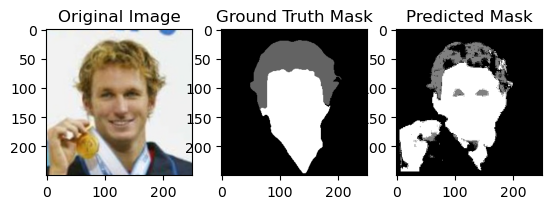

In [6]:
model.eval()

# Get the specific image and mask from the dataset
lfw_dataset = LFWDataset(download=False, base_folder='..\cvdl_lab_4\lfw_dataset', transforms=None)
index_to_inspect = 0
image, mask = lfw_dataset[index_to_inspect]

# Convert the image to the format expected by the model
image_tensor = torch.unsqueeze(torch.transpose(torch.tensor(image), 0, 2), 0).float()

# Make a prediction using the model
with torch.no_grad():
    model_output = model(image_tensor)

# Assuming your model produces class scores for each pixel, you can use argmax to get the predicted class for each pixel
predicted_mask = torch.argmax(model_output, dim=1).squeeze().numpy()
print(np.unique(predicted_mask))
print(np.unique(mask))

# Rotate the predicted mask to match the orientation of the original image and ground truth mask
predicted_mask_rotated = np.rot90(predicted_mask, k=-1)

# Flip the rotated predicted mask horizontally
predicted_mask_final = np.fliplr(predicted_mask_rotated)

# Visualize the original image, ground truth mask, and predicted mask
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title('Ground Truth Mask')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_final, cmap='gray')
plt.title('Predicted Mask')

plt.show()

In [7]:
scripted_model = torch.jit.script(model)

# Save the scripted model to a file
scripted_model.save("scripted_unet.pt")